# Predicting Company Bankruptcy using Machine Learning

## Table of Contents
* [Chapter 1: Project Overview](#chapter1)
    * [1.1 Project Motivation](#section1_1)
    * [1.2 Dataset Description](#section1_2)
    * [1.3 Methodologies](#section1_3)
* [Chapter 2: Data Preparation](#chapter2)
    * [2.1 Data Collection](#section2_1)
    * [2.2 Data Exploration (EDA)](#section2_2)
    * [2.3 Data Pre-Processing](#section2_3)
* [Chapter 3: Modelling](#chapter3)
    * [3.1 Evaluation Metrics](#section3_1)
    * [3.2 Machine Learning Models](#section3_2)
    * [3.3 Modelling Evaluations](#section3_3)
* [Chapter 4: Results](#chapter4)

## Chapter 1: Project Overview <a id="chapter1"></a>

In this chapter, we present our project motivation, give a description of the dataset and an overview of our project methodologies.

### 1.1 Project Motivation <a id="section1_1"></a>
In today's dynamic business landscape, exemplified by recent events such as the bankruptcy of Silicon Valley Bank, the ability to anticipate and mitigate financial risks is crucial for sustainable growth and stability. This project aims to develop a robust predictive model of company bankruptcy, leveraging advanced machine learning algorithms and financial data analysis techniques, so as to equip stakeholders with nuanced insights to confidently traverse the unpredictable landscape of financial risk.

### 1.2 Dataset Description <a class="anchor" id="section1_2"></a>
The dataset used in this project is about bankruptcy prediction of Polish companies. The dataset contains financial rates from one year and corresponding class label that indicates bankruptcy status 3 years after that year. The data contains 10503 instances (financial statements), with 495 representing bankrupted companies and 10008 still operating at the end of the 3-year forecasting period.

The data was collected from [Emerging Markets Information Service](http://www.securities.com), which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.  

Source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data)

### 1.3 Methodologies <a class="anchor" id="section1_3"></a>
This project is structured into five distinct steps:

1. **Data Collection**  
2. **Exploratory Data Analysis (EDA)**  
3. **Data Pre-processing**  
4. **Modeling**  
5. **Evaluation and Comparison**  

In [1]:
# Required libraries:
import sys

# List of required packages
required_packages = [
    "numpy",
    "pandas",
    "scikit-learn",
    "imbalanced-learn",
    "matplotlib",
    "seaborn",
    "scipy",
    "black",
    "isort",
    "plotly",
    "torch",
]

# Install the required packages (Uncomment line below to install)
#!{sys.executable} -m pip install {' '.join(required_packages)}

## Chapter 2: Data Preparation <a class="anchor" id="chapter2"></a>

### 2.1 Data Collection <a class="anchor" id="section2_1"></a>

In [2]:
import requests
import zipfile
import os
from scipy.io import arff
import pandas as pd

In [3]:
source_url = (
    "https://archive.ics.uci.edu/static/public/365/polish+companies+bankruptcy+data.zip"
)
dest_url = "../data/downloaded_file.zip"


def get_zip_file(source_url, dest_url):
    response = requests.get(source_url)
    with open(dest_url, "wb") as zipfile:
        zipfile.write(response.content)


def extract_arff_from_zip(zip_path, arff_filename, extraction_path="."):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extract(arff_filename, path=extraction_path)
        return os.path.join(extraction_path, arff_filename)


def convert_arff_to_csv(arff_path, csv_path):
    data, meta = arff.loadarff(arff_path)
    df = pd.DataFrame(data)
    for col in df.select_dtypes([object]):
        if isinstance(df[col][0], bytes):
            df[col] = df[col].apply(lambda x: x.decode("utf-8"))
    df.to_csv(csv_path, index=False)


def save_file():
    for i in range(1, 6):
        arff_filename = f"{i}year.arff"
        csv_path = f"{i}year.csv"
        extracted_arff_path = extract_arff_from_zip(dest_url, arff_filename)
        convert_arff_to_csv(extracted_arff_path, csv_path)


# uncomment the two lines below to re-download raw data files

# get_zip_file(source_url, dest_url)
# save_file()

In [4]:
# read raw data files into pandas dataframe for data exploration and engineering in the following sections
df = pd.read_csv("../../data/3year.csv")
df_origin = df.copy()

##### Dataset overview

In [5]:
# uncomment the following lines to see an overview of the dataset
# inspect the shape of the dataset
# df.shape
# inspect the class of columns
# df.info()

Our dataset consists of 10503 rows and 65 columns. The first 64 columns form the feature space, while the last column is the target column with the true labels, while 1 denotes bankruptcy status and 0 otherwise. The names of the feature columns are shown below.

The function below converts the target column to binary values for easier analysis.

In [6]:
def as_discrete(col):
    n = len(col)
    new_col = [0] * n
    for i in range(n):
        if col[i] == "b'0'":
            new_col[i] = 0
        else:
            new_col[i] = 1
    return pd.DataFrame(new_col)

In [7]:
feature_space = df.iloc[:, 0:64]
target_column = df.iloc[:, 64]
df = pd.concat([feature_space, as_discrete(target_column)], axis=1)

df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,0
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


### 2.2 Data Exploration (EDA) <a class="anchor" id="section2_2"></a>

#### 2.2.1 Visualization <a id="section2_2_1"></a> 

In this stage, we examined the feature columns and their data types to gain a comprehensive understanding of the dataset, including its size, structure, and characteristics. By visualizing the data through various plots and charts, data exploration enables the detection of patterns, trends, and relationships between different variables. This can provide valuable insights into the underlying relationships within the data.

We use histograms, box plots, and density plots to visually explore the distribution of each feature. By using scatter plots and heat maps, we explore the correlation and relationship within each pair of features to ease the feature selection process.

Exploring the data allows for the assessment of data quality, including issues such as data inconsistencies, errors, or biases. This ensures that the data used for analysis is reliable and representative of the underlying phenomena.



In [8]:
# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# mute warning messages
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# make a copy of the datasets for visualization
df_graph = df.copy()

##### Missingness Map
We first plot a missingness map to see the sparsity of our dataset.

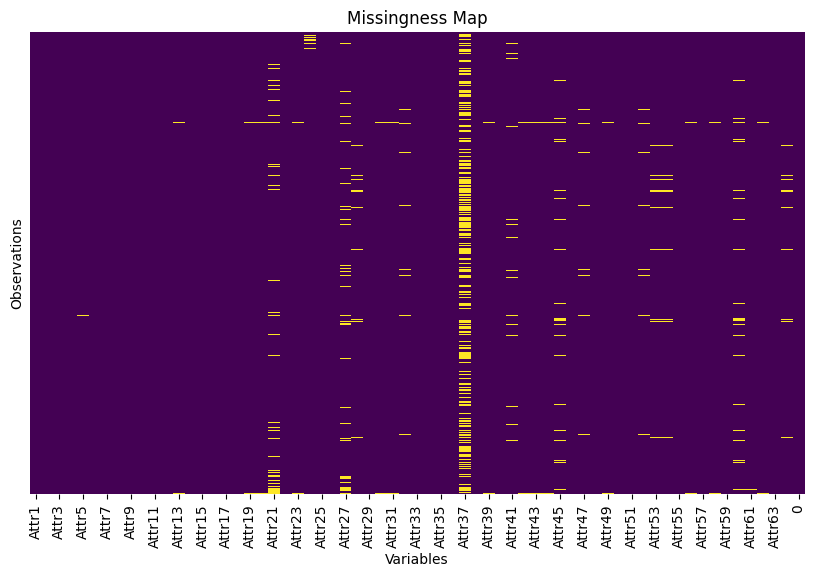

In [9]:
# Create a missingness matrix
missing_values = df_graph.isnull()

# Plot the missingness map
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cmap="viridis", cbar=False)
plt.title("Missingness Map")
plt.xlabel("Variables")
plt.ylabel("Observations")
plt.yticks([])
plt.show()

In [10]:
# Find the number of null values in each column
null_counts = df_graph.isnull().sum()
print("Number of null values in each column:")
print(null_counts)

# Calculate the threshold for more than 40% of the entries to be null
threshold = df_graph.shape[0] * 0.4

# Use boolean indexing to filter columns where the number of null values exceeds the threshold
columns_with_many_nulls = df_graph.columns[df_graph.isnull().sum() > threshold]

print("Columns where more than 40% of the entries are null:")
print(columns_with_many_nulls)

Number of null values in each column:
Attr1       0
Attr2       0
Attr3       0
Attr4      18
Attr5      25
         ... 
Attr61     17
Attr62     43
Attr63     18
Attr64    228
0           0
Length: 65, dtype: int64
Columns where more than 40% of the entries are null:
Index(['Attr37'], dtype='object')


##### Histogram
The second step of our exploratory data analysis is to use histograms to study the distrbutions of each feature column as well as the target column. From the result (single or two high bars), we found that almost all features have far outliers.

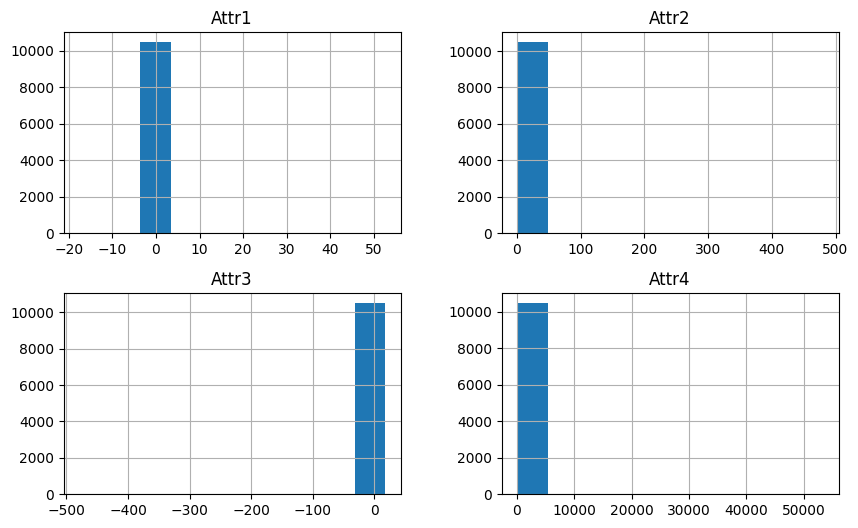

In [11]:
# Here we illustrate the histogram distribution for the first 10 features
df_graph.iloc[:, 0:4].hist(figsize=(10, 6))  # figsize is optional, adjust as needed
plt.show()

##### Boxplot

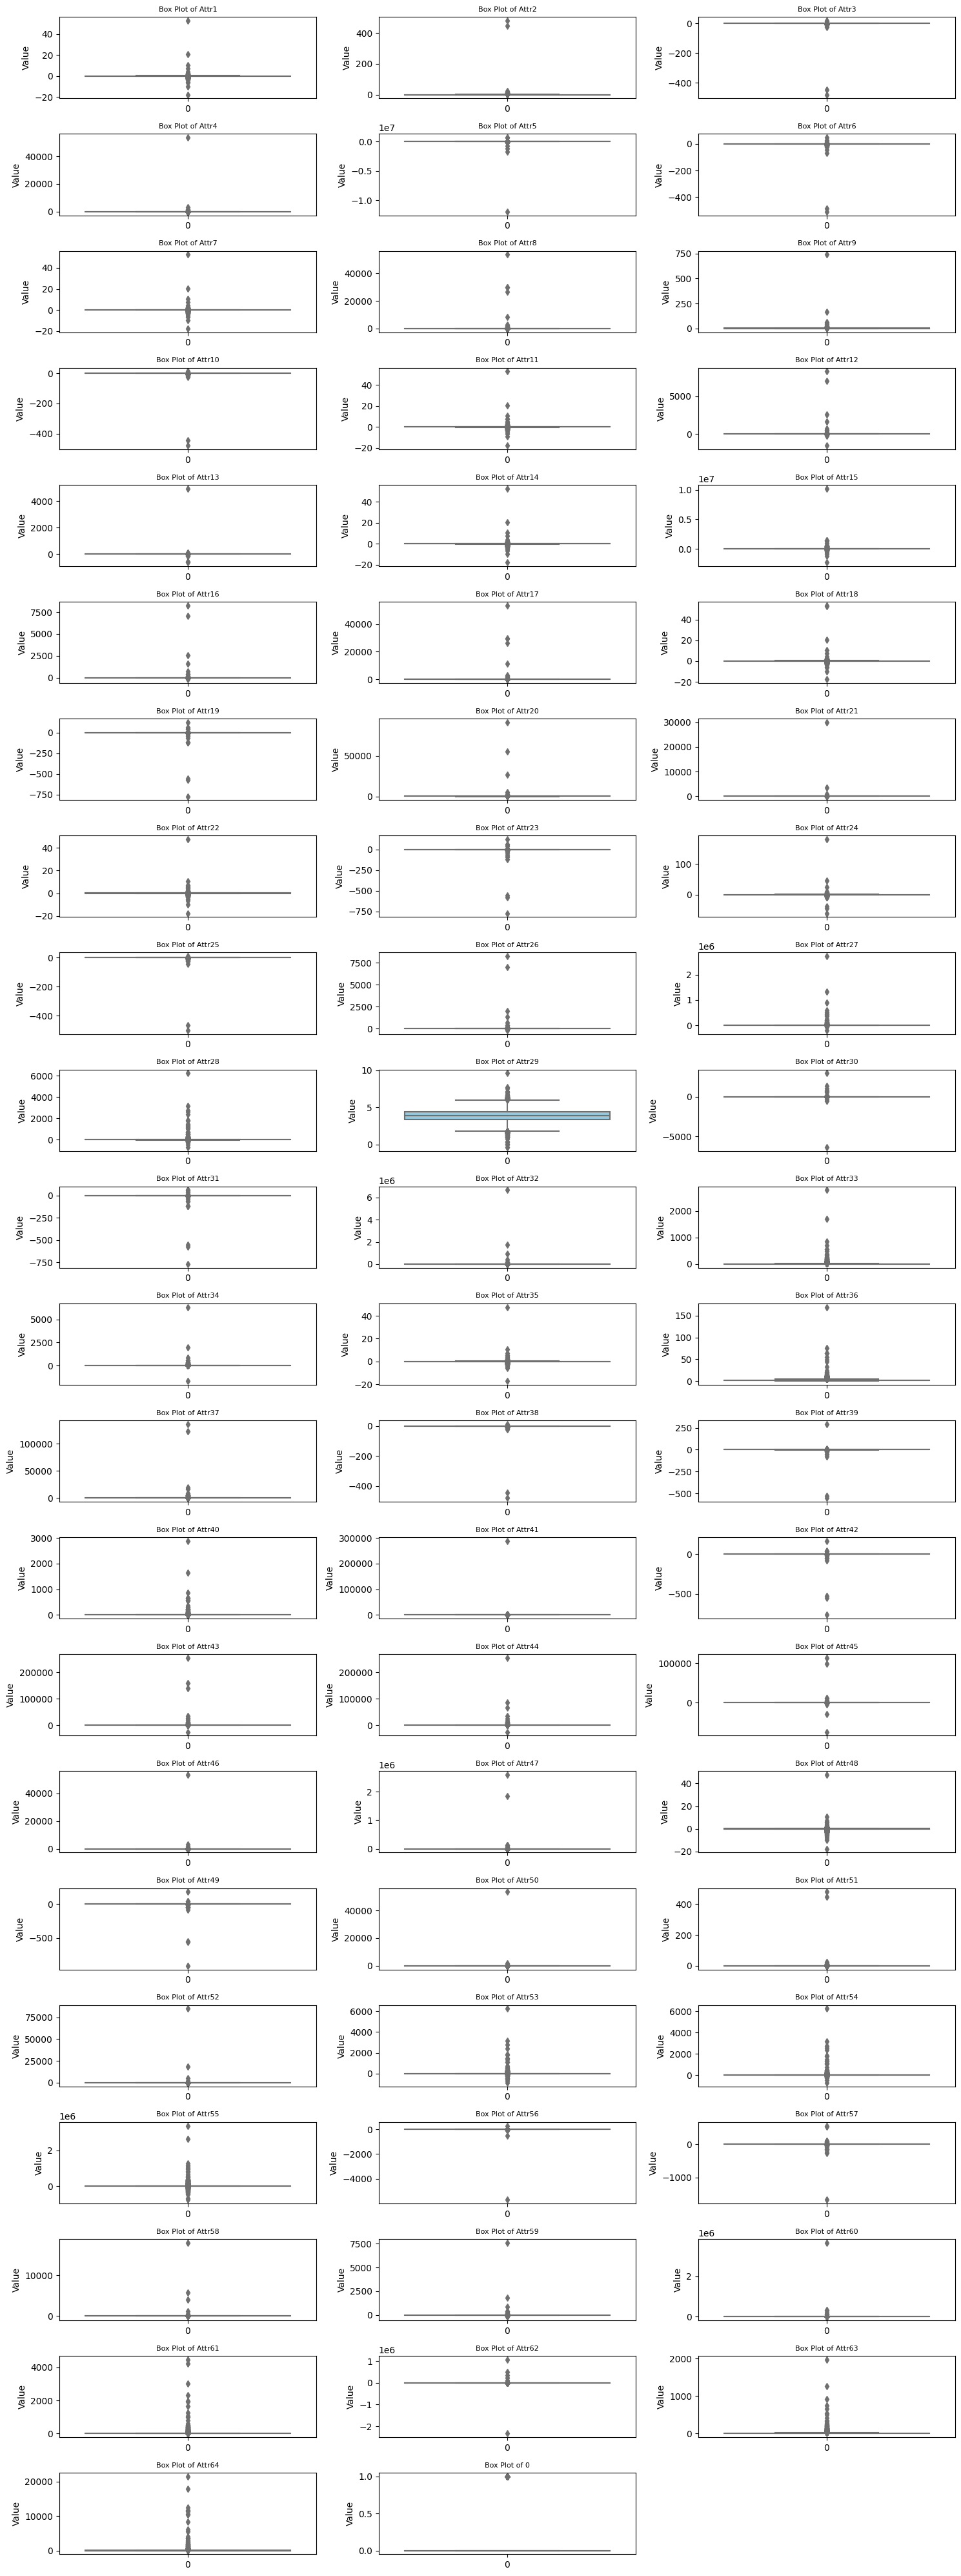

In [85]:
plt.figure(figsize=(15, 40))
i = 1
for column in df_graph.columns:
    plt.subplot(22, 3, i)  # Adjust layout as needed
    i += 1
    sns.boxplot(data=df_graph[column], color="skyblue")
    plt.title(f"Box Plot of {column}", fontsize=8)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

#### 2.2.2 Detection of Outliers<a id="section2_2_2"></a>
In the realm of data analysis, outliers represent data points that stray considerably from the general pattern observed in a dataset. These outliers possess the potential to heavily influence the performance of models employed in analysis. Through thorough exploration of the data, outliers can be pinpointed, allowing for informed decisions on how to address them, whether by removal or transformation, to minimize their impact on the overall analysis.

Upon examining the visualizations provided above, it becomes apparent that the majority of features exhibit a notable presence of outliers. Consequentlywetapproached to o remove these outliers, aiming to achieve clearered understanding of the underlying distribution of these features.

##### Outlier Removal

In [12]:
# Define a function to remove outliers based on 1.5 * IQR for each feature
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]


# Remove outliers for each feature and plot histograms
clean_list = []
for column in df_graph.columns:
    cleaned_data = remove_outliers(df_graph[column])
    clean_list.append(cleaned_data)

Below are the visualizations based on the outliers removed data set.

##### Histogram (After Outlier Removal)

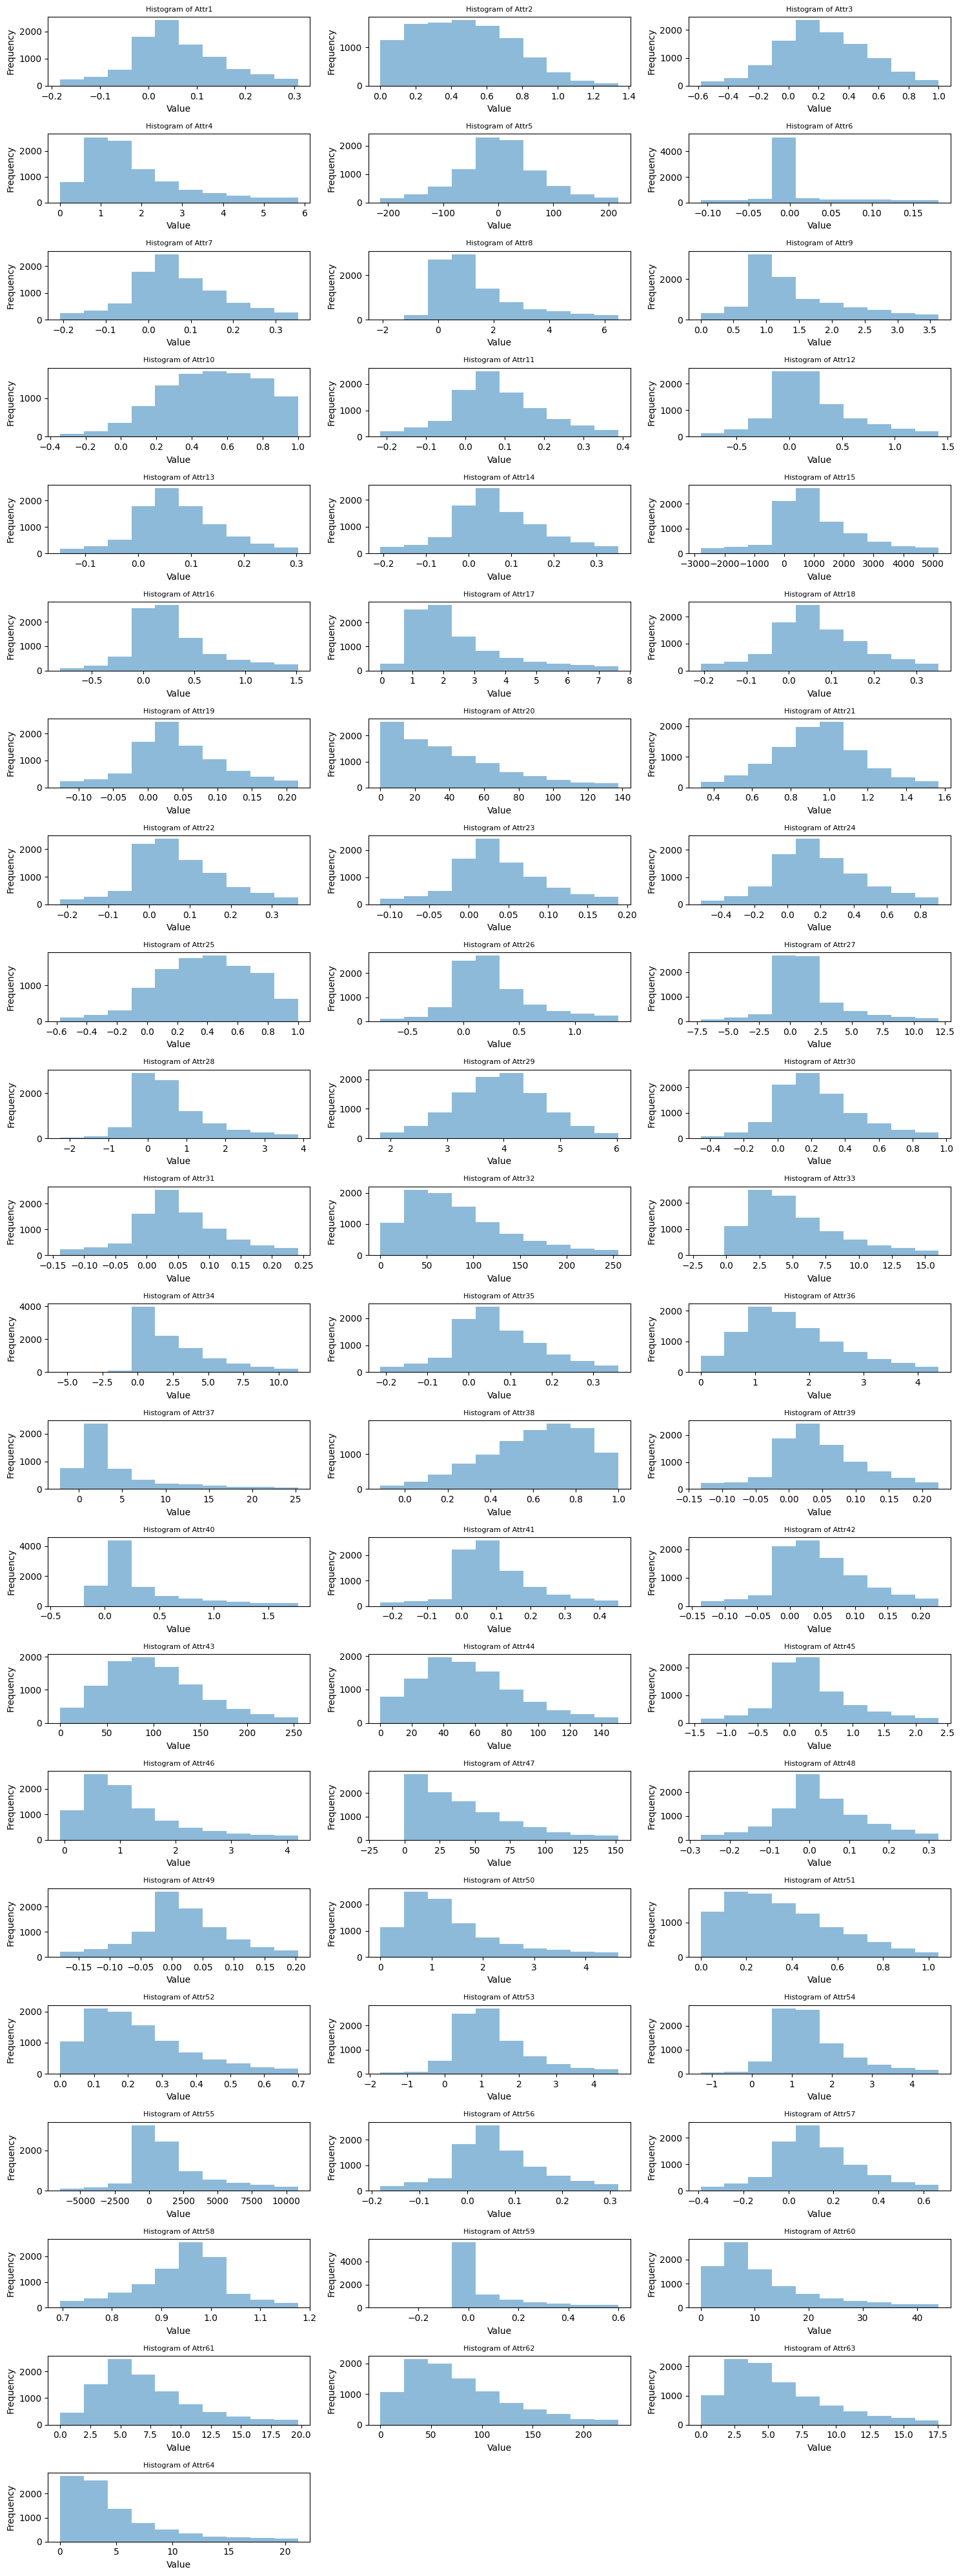

In [21]:
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list[: len(clean_list) - 1], start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    plt.hist(series, bins=10, alpha=0.5)
    plt.title(f"Histogram of {series.name}", fontsize=8)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##### Density plots (After Outlier Removal)

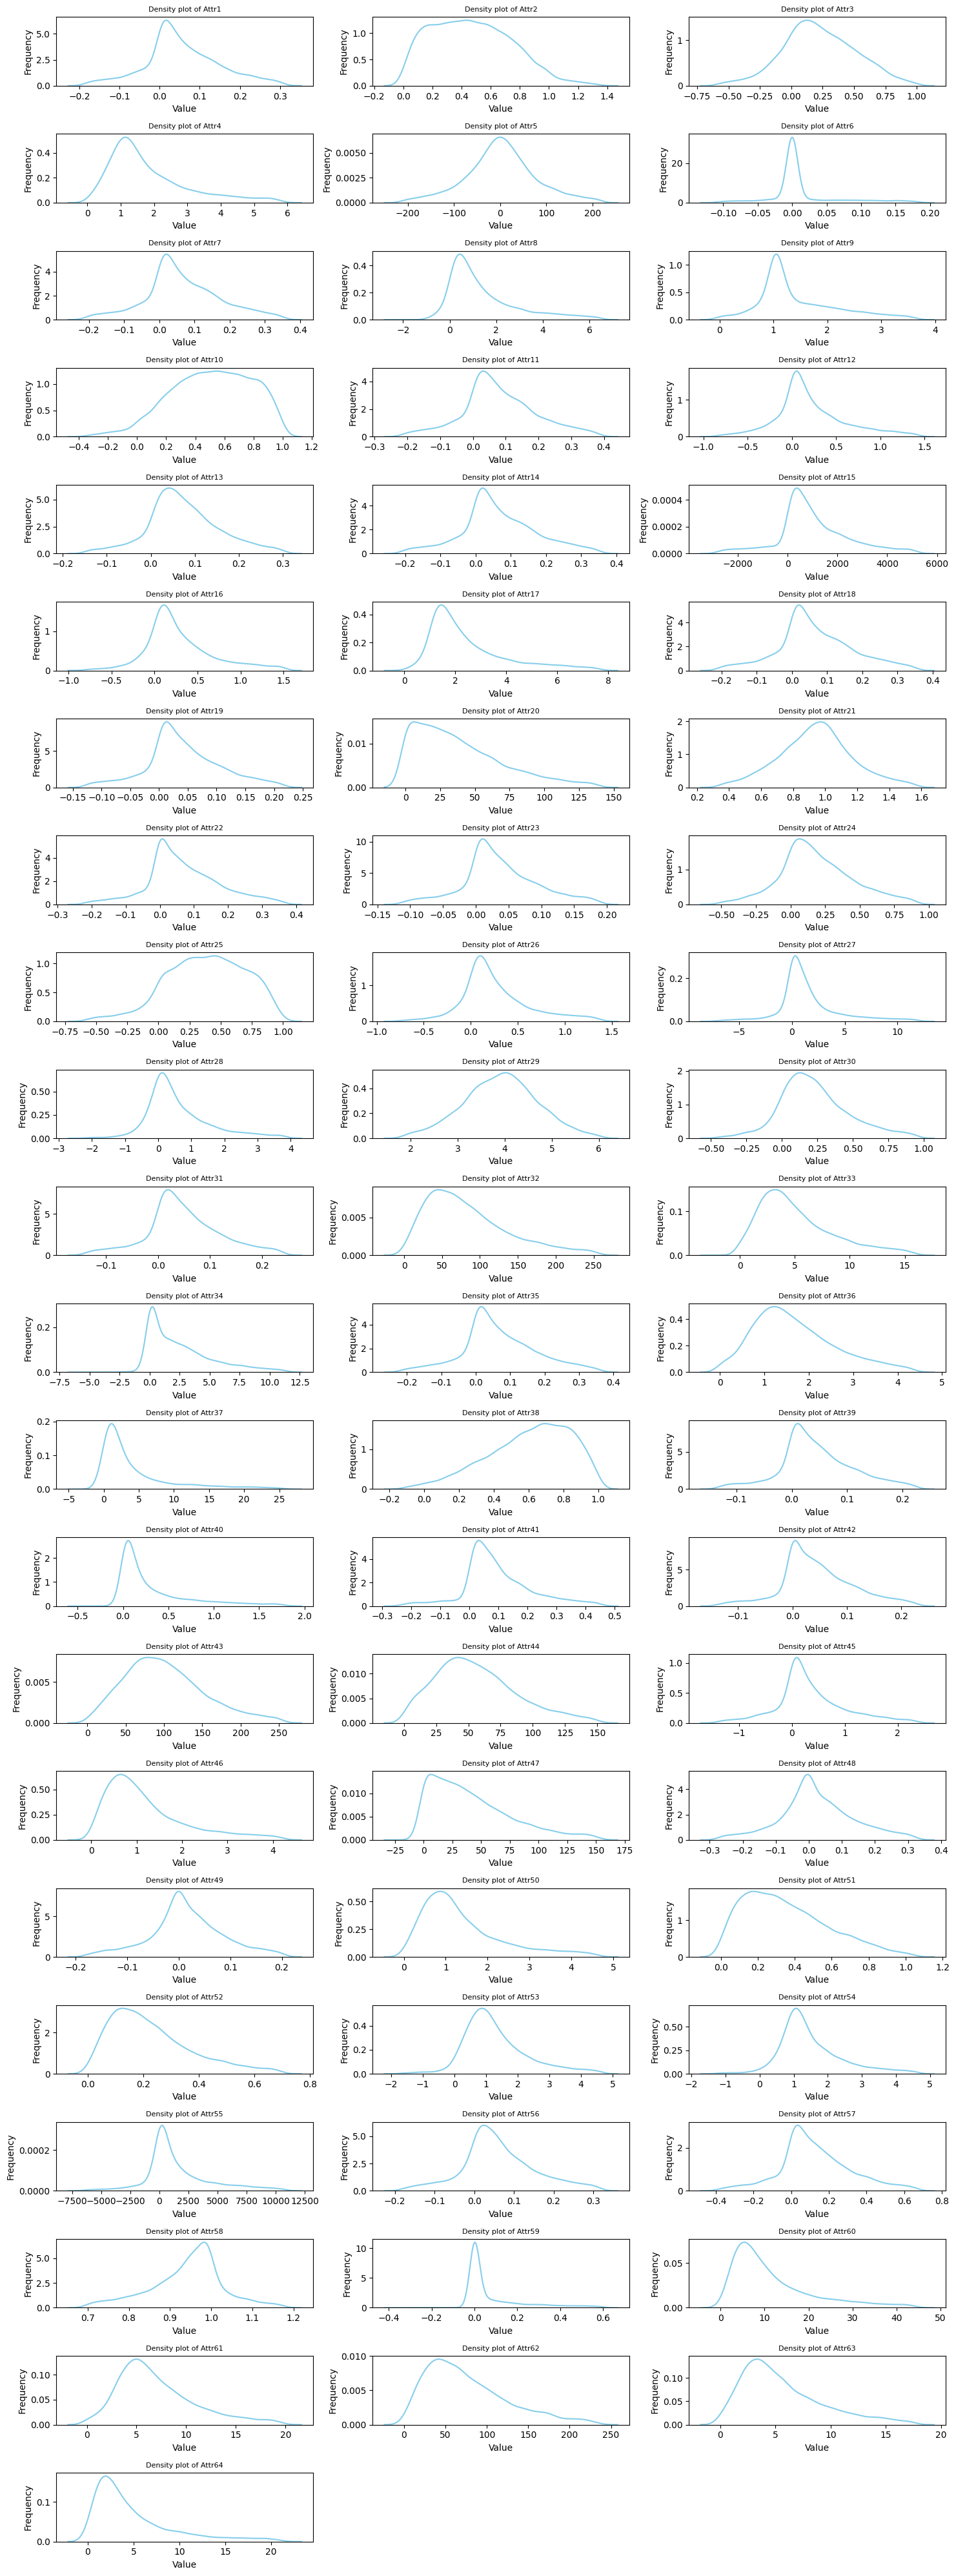

In [22]:
import warnings

warn_singular = False
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list[: len(clean_list) - 1], start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    sns.kdeplot(series, color="skyblue")
    plt.title(f"Density plot of {series.name}", fontsize=8)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##### Box plots

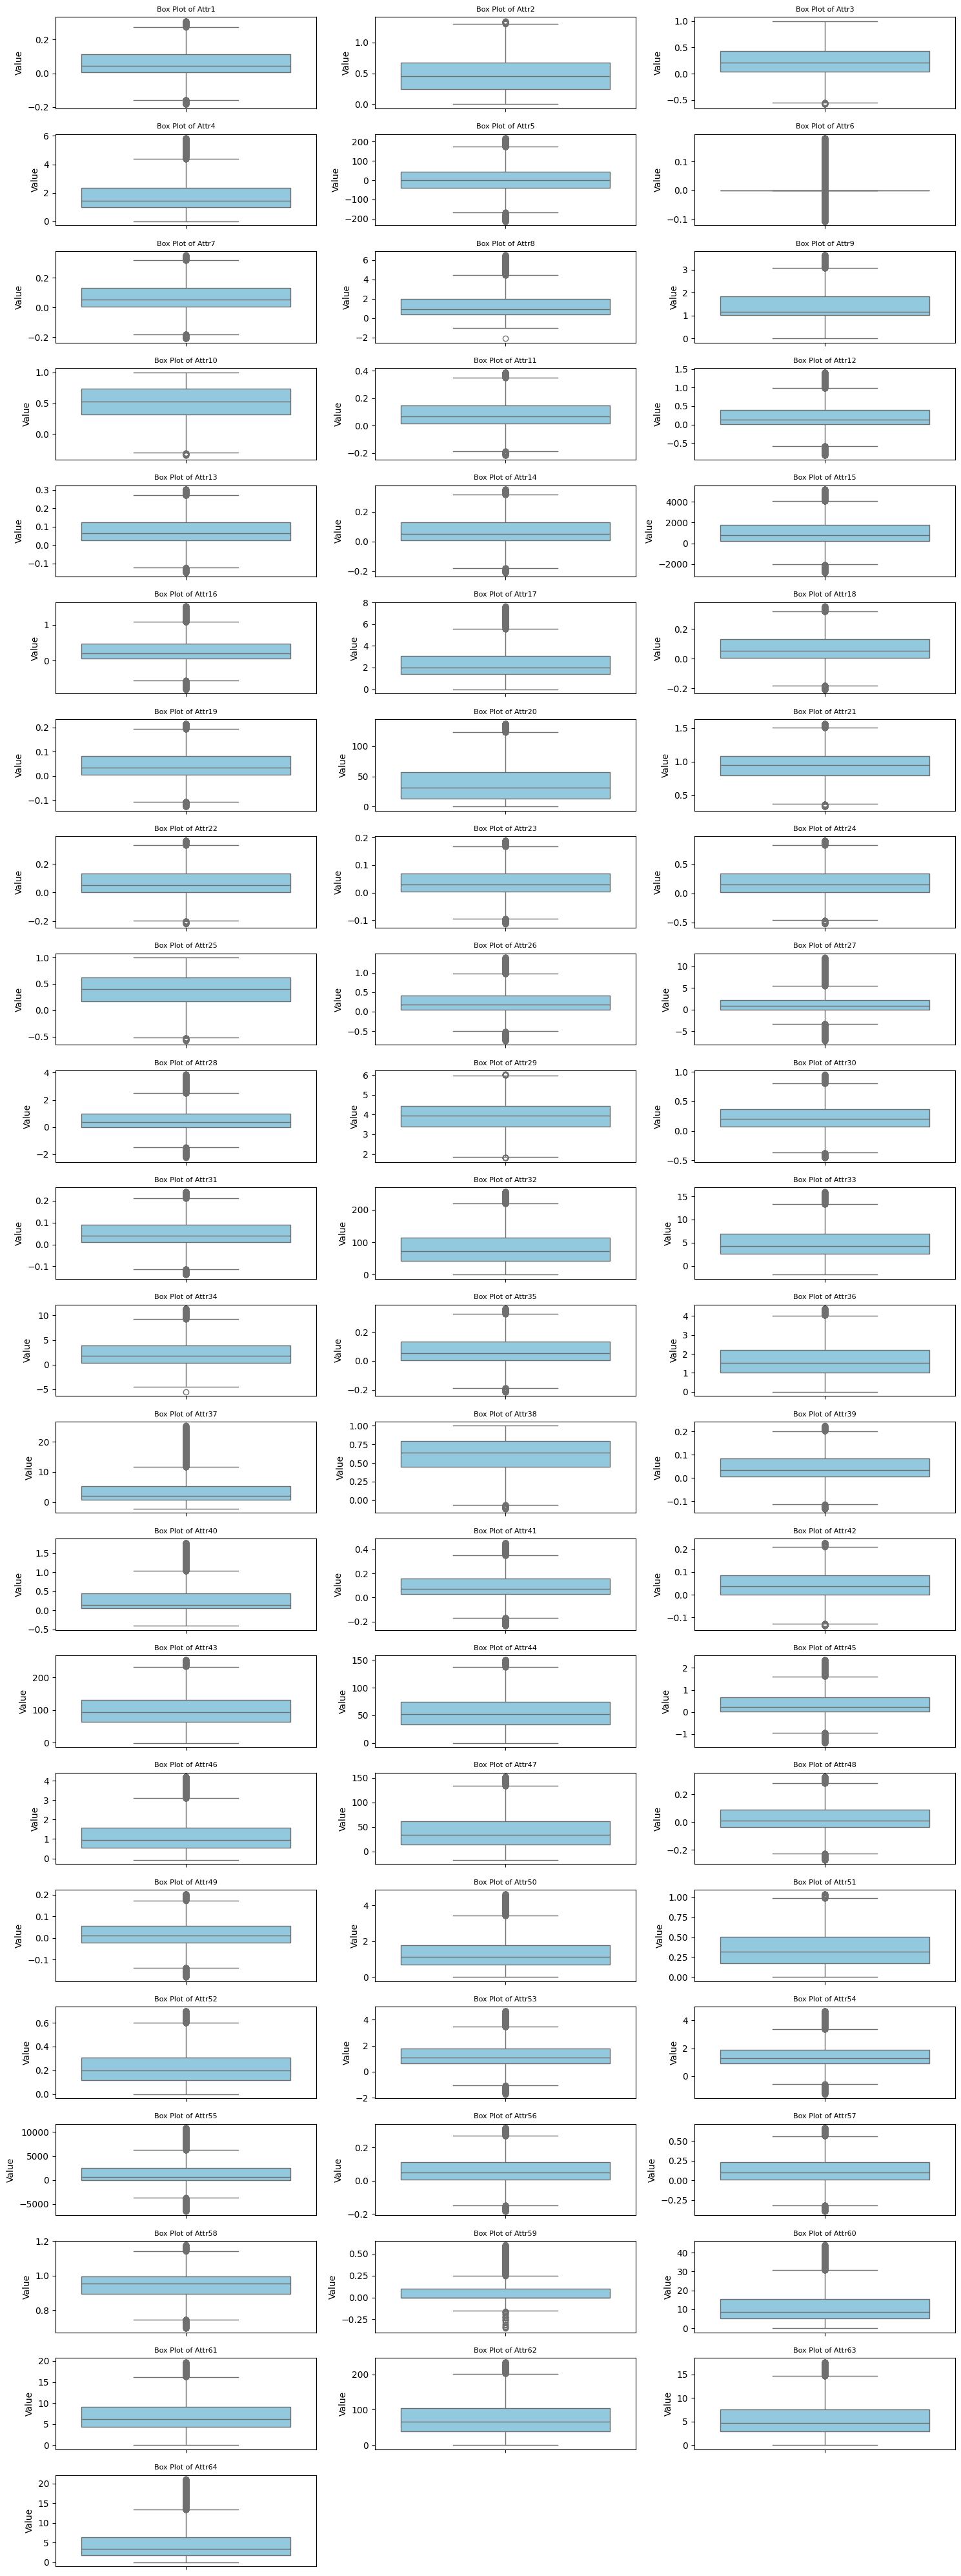

In [23]:
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list[: len(clean_list) - 1], start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    sns.boxplot(data=series, color="skyblue")
    plt.title(f"Box Plot of {series.name}", fontsize=8)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

After removing the outliers, it becomes apparent that the majority of features exhibit smoother distributions. Nonetheless, due to the substantial presence of outliers, we have opted against their removal in subsequent data processing steps to prevent information loss.




### 2.3 Data Pre-Processing <a class="anchor" id="section2_3"></a>

In this section, we prepare our dataset by performing data pre-processing. Raw data often contains inconsistencies, missing values, and outliers that can negatively impact the performance of machine learning models. Data pre-processing ensures the data is clean, consistent, and formatted appropriately for our modelling tasks.

In [90]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

The function below splits the feature space and the target column.

In [91]:
# function to separate features and target
def get_Xy(df):
    X = df.iloc[:, 0 : len(df.columns) - 1]
    y = df.iloc[:, -1]
    return X, y

From EDA, it is observed that there are many missing values in the dataset. We removed the column with more than 40% values missing as it is a significant loss of information. Rows with more than half of the values missing are also removed. For the remaining missing values, median imputation is used in view of the presence of drastic outliers in the dataset. 

In [92]:
# function to handle missing values
def med_impute(df, y):
    # remove columns with more than 40% values being null
    thd1 = df.shape[0] * 0.4
    cols = df.columns[df.isnull().sum() < thd1]
    df = df[cols]

    # remove rows with more than 50% values being null
    thd2 = df.shape[1] * 0.5
    y = y[df.isnull().sum(axis=1) <= thd2]
    df = df[df.isnull().sum(axis=1) <= thd2]

    # median imputation for null values
    df = df.fillna(df.median())

    return df, y

The function is to normalise numerical columns to remove effect of inconsistent scales between feature columns.

In [93]:
def normalise(df):
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return X_scaled

The function is to drop columns that are of strong correlation with one or more other feature column(s) to remove the adverse effect of multicollinearity on subsequent classification result. 

In [94]:
# function for feature selection
def drop_high_corr(df, threshold=0.7):
    correlation_matrix = df.corr()
    high_cor = []
    dropped_features = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                if correlation_matrix.columns[j] != correlation_matrix.columns[i]:
                    high_cor.append(
                        [
                            correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j],
                        ]
                    )

    for pair in high_cor:
        feature1, feature2, correlation = pair
        if feature1 not in dropped_features and feature2 not in dropped_features:
            if feature2 in df.columns:
                df.drop(feature2, axis=1, inplace=True)
                dropped_features.append(feature2)
            else:
                print("Feature '" + feature2 + "' not found in the DataFrame.")
    return df

In [95]:
def process0(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return X_scaled_df, y


# function to pre-process the data
def process1(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return drop_high_corr(X_scaled_df), y


# function to obtain train and test sets
def process2(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

    return X_train, X_test, y_train, y_test


# function to obtain train and test sets with sythesised instances of the minority class
def pre_process(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_train = smote.fit_resample(X_train, y_train)

    return X_smote, X_test, y_train, y_test

### 2.3.1 ANOVA test for feature selection
We will also perform feature selection for our dataset, because irrelavant features can:
- **Increase Model Complexity**: Unnecessary features can lead to overfitting, where the model performs well on training data but poorly on unseen data.
- **Reduce Model Interpretability**: A large number of features makes it difficult to understand how the model arrives at its predictions.
- **Slow Down Training Time**: Training models with irrelevant features takes longer and consumes more computational resources.

One method of feature selection is ANOVA test, defined in: `get_df_with_top_k_features` and `find_best_k_features_from_ANOVA`

**ANOVA (Analysis of Variance)** is a statistical test used in feature selection to identify features that have a significant influence on the target variable. Here's how it helps select the best k features (where k is a chosen number):

- Focuses on Variance: ANOVA analyses the variation in a feature's values. It compares the variation between groups (bankrupt vs. non-bankrupt) to the variation within each group.
- Low p-value indicates Impact: Features with a low p-value (from the F-statistic) suggest a strong statistical difference in the feature's values between bankrupt and non-bankrupt companies. This implies the feature likely has a real impact on predicting bankruptcy.

In [96]:
def plot_ANOVA_test_graph(train_acc_dict, test_acc_dict):
    # Extract keys and values from train_acc_dict and test_acc_dict
    train_k_values, train_accuracy_values = zip(*train_acc_dict.items())
    test_k_values, test_accuracy_values = zip(*test_acc_dict.items())

    plt.figure(figsize=(6, 4))
    # Plot train accuracy
    plt.plot(
        train_k_values, train_accuracy_values, label="Train Accuracy", color="blue"
    )
    # Plot test accuracy
    plt.plot(test_k_values, test_accuracy_values, label="Test Accuracy", color="green")

    # Find k values corresponding to maximum accuracies
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)
    best_train_accuracy = train_acc_dict[best_train_k]
    best_test_accuracy = test_acc_dict[best_test_k]

    # Annotate the point corresponding to the peak train accuracy
    plt.annotate(
        f"Max Train Accuracy\nk={best_train_k}, Acc={best_train_accuracy:.2f}",
        xy=(best_train_k, best_train_accuracy),
        xytext=(-30, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="blue"),
    )

    # Annotate the point corresponding to the peak test accuracy
    plt.annotate(
        f"Max Test Accuracy\nk={best_test_k}, Acc={best_test_accuracy:.2f}",
        xy=(best_test_k, best_test_accuracy),
        xytext=(30, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    # Label axes and add title
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Number of Features from ANOVA test")

    plt.legend()
    plt.show()


## Note: *args follow the convention X_train, X_test, y_train, y_test
def get_df_with_top_k_features(k_features, *args):  # after pre_process(df)
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=k_features)

    # apply feature selection
    fs.fit_transform(X_train, y_train)

    # Take the features with the highest F-scores
    fs_scores_array = np.array(fs.scores_)

    # Get the indices that would sort the array in descending order
    sorted_indices_desc = np.argsort(fs_scores_array)[::-1]

    # Take the top k indices
    top_indices = sorted_indices_desc[:k_features]

    selected_columns_X_train = X_train.iloc[:, top_indices]
    selected_columns_X_test = X_test.iloc[:, top_indices]

    return selected_columns_X_train, selected_columns_X_test, y_train, y_test


def find_best_k_features_from_ANOVA(model, *args):

    X_train = args[0]
    original_n_features = len(X_train.columns)

    train_acc_dict = {}  # 0 is a dummy accuracy for k=0 features
    test_acc_dict = {}
    train_test_dataset = {}

    for k in range(1, original_n_features + 1):
        print(f"k: {k}")
        train_test_dataset_after_ANOVA = get_df_with_top_k_features(k, *args)
        train_accuracy, test_accuracy = model(*train_test_dataset_after_ANOVA)
        train_test_dataset[k] = train_test_dataset_after_ANOVA
        train_acc_dict[k] = train_accuracy
        test_acc_dict[k] = test_accuracy

    # Find k that gives the highest accuracy
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)

    print(f"\033[96mBest k for train_accuracy:\033[00m {best_train_k}")
    print(f"\033[96mBest k for test_accuracy:\033[00m {best_test_k}")

    plot_ANOVA_test_graph(train_acc_dict, test_acc_dict)

    return train_test_dataset[best_test_k]

Moving forward, we can use ANOVA test for feature selection to reduce the number of features in our dataset before building our model.

<AxesSubplot: >

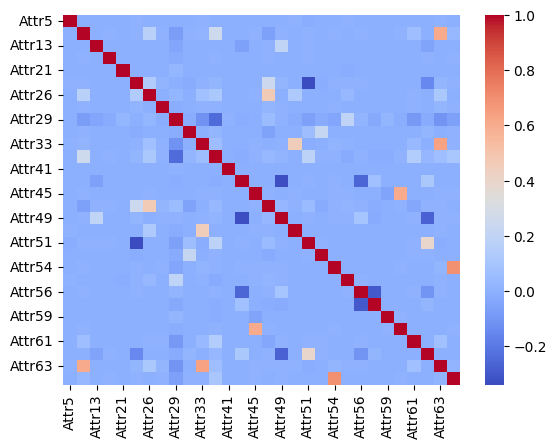

In [97]:
# We use the pre-processing function 'process1' to get the feature space where no feature pair has a correlation value higher than 0.7.
X_heatmap, y_heatmap = process1(df_graph)
sns.heatmap(X_heatmap.corr(), annot=False, cmap="coolwarm")

### 2.3.2 Filter Method for Feature Selection

Filter method is a feature selection method in the preprocessing step, and it is independent of the machine learning algorithm deployed afterwards. In our case, we implemented two filtering method, based on Information Gain (IG) and Correlation respectively.

1. **Information Gain (IG)**: This method measures the reduction in entropy from transforming a dataset in some way. It is often used in training decision trees. Information Gain can be applied to feature selection by evaluating the mutual information between each feature and the target variable. Features that have higher mutual information with the target variable are considered more informative and are thus selected.

2. **Correlation**: This is a statistical measure that describes the size and direction of a relationship between variables. In feature selection, we often look for features that have a high correlation with the target variable but are not highly correlated with each other, to avoid redundancy.

For both functions, we sort the features based on their scores in descending order. Higher scores indicate more important features.

For better judging the optimal number of feature, we define a function `plot_feature_performance` to evaluate the performance of a model (balaneced Random Forest as example) as we vary the number of top features used. Finally, it plots the performance metrics f1 and recall (explained in the next chapter) against the number of features. With the aid of the plot, we determine the point of diminishing return through elbow method, selecting the optimal number of features.


In [98]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score


def information_gain(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def correlation_selection(X, y):
    if isinstance(y, pd.Series):
        y = y.to_frame(name="Target")
    elif isinstance(y, pd.DataFrame):
        y.columns = ["Target"]

    df_combined = pd.concat([X, y], axis=1)
    correlation_matrix = df_combined.corr()
    correlation_w_target = correlation_matrix["Target"].drop("Target")
    return correlation_w_target.abs().sort_values(ascending=False)


def plot_feature_performance(X, y, score_series, model, max_features=None):
    f1_results = []
    recall_results = []
    feature_counts = []

    if not max_features:
        max_features = len(score_series)

    for i in range(1, max_features + 1):
        top_features = score_series.nlargest(i).index
        X_selected = X[top_features]

        # Cross-validation F1 and recall scores
        f1 = cross_val_score(model, X_selected, y, cv=5, scoring="f1")
        recall = cross_val_score(model, X_selected, y, cv=5, scoring="recall")

        f1_results.append(f1.mean())
        recall_results.append(recall.mean())
        feature_counts.append(i)

    # Plotting the F1-score and recall results
    plt.figure(figsize=(10, 6))
    plt.plot(
        feature_counts,
        f1_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="F1 Score",
    )
    plt.plot(
        feature_counts,
        recall_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="Recall",
    )
    plt.xlabel("Number of Features")
    plt.ylabel("Score")
    plt.title("Model Performance vs. Number of Features")
    plt.legend()
    plt.grid(True)
    plt.show()

### 2.3.3 Wrapper Method for Feature Selection

The wrapper method for feature selection is a technique used to identify the most significant features for a predictive model. It works by starting with an empty set and adding features one by one, each time choosing the feature that, when added, most improves the model's F1 score - our desirable metric. This approach is iterative and selects features based on their contribution to the model's predictive accuracy.

In [99]:
from sklearn.metrics import f1_score


def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    selected_features = []
    best_f1 = 0
    features = list(X_train.columns)

    for _ in range(len(features)):
        f1_scores = []
        for feature in features:
            if feature not in selected_features:
                temp_features = selected_features + [feature]
                model.fit(X_train[temp_features], y_train)
                y_pred = model.predict(X_test[temp_features])
                f1 = f1_score(y_test, y_pred)
                f1_scores.append((feature, f1))

        # Find the best feature and its f1 score
        f1_scores.sort(key=lambda x: x[1], reverse=True)
        best_feature, best_feature_f1 = f1_scores[0]

        if best_feature_f1 > best_f1:
            print(f"Adding {best_feature} improved F1 to {best_feature_f1}")
            best_f1 = best_feature_f1
            selected_features.append(best_feature)
        else:
            break

    print("Selected features:", selected_features)
    return selected_features

Here we use a heatmap to visualise the correlation relationship within each pair of features to ease the feature selection process to validate our previous feature selection step.

## Chapter 3: Modelling <a class="anchor" id="chapter3"></a>

### 3.1 Evaluation Metrics  <a class="anchor" id="section3_1"></a>

Our primary task is to predict bankruptcy (a classification problem). Below are the key classification metrics that we will use to evaluate our model performance:

#### 3.1.1 Accuracy
Accuracy provides a ratio of correctly predicted observations to the total observations. It is especially useful when the classes are balanced with SMOTE.

**Formula**:
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

#### 3.1.2 Confusion Matrix and Related Terms
The confusion matrix is a table layout that allows visualization of the performance of the algorithm, where each number in the matrix represents:
- **TP (True Positives)**: Correctly predicted positive observations.
- **TN (True Negatives)**: Correctly predicted negative observations.
- **FP (False Positives)**: Incorrectly predicted as positive.
- **FN (False Negatives)**: Incorrectly predicted as negative.

#### 3.1.3 Precision, Recall, and F1-Score
These metrics offer a deeper understanding of the model's performance by taking into account data imbalances, thereby providing a more nuanced view of the accuracy across different class labels.

- **Precision**:
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
Precision measures the accuracy of positive predictions.

- **Recall** (or Sensitivity or TPR):
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
Recall measures the ability of a model to find all the relevant cases (all positive samples).

- **F1-Score**:
$$ \text{F1-Score} = 2 \times \left( \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \right) $$
The F1-Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. A high F1-score shows a model can classify the positive class correctly, while not misclassifying many negative classes as positive.

In bankruptcy prediction, avoiding false negatives is crucial due to their greater potential costs compared to false positives. Hence, we focus on the F1 score and recall in our model evaluation. The F1 score balances precision with recall, penalizing false negatives, while a high recall ensures most bankruptcy cases are correctly identified. These metrics are more indicative of our model's performance for this task than mere accuracy.

In [100]:
# import evaluation metrics
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


# function to print all evaluation results
def get_acc(y_test, y_pred):
    return round(accuracy_score(y_test, y_pred), 3)


def get_pre(y_test, y_pred):
    return round(precision_score(y_test, y_pred), 3)


def get_rec(y_test, y_pred):
    return round(recall_score(y_test, y_pred), 3)


def get_f1(y_test, y_pred):
    return round(f1_score(y_test, y_pred), 3)


def print_res(y_test, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {get_acc(y_test, y_pred)}")
    print(f"Precision Score: {get_pre(y_test, y_pred)}")
    print(f"Recall Score: {get_rec(y_test, y_pred)}")
    print(f"F1 Score: {get_f1(y_test, y_pred)}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")


def print_kfold_res(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = {"accuracy": [], "precision": [], "recall": [], "f1": []}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["precision"].append(precision_score(y_test, y_pred, average="binary"))
        scores["recall"].append(recall_score(y_test, y_pred, average="binary"))
        scores["f1"].append(f1_score(y_test, y_pred, average="binary"))

    mean_scores = {key: np.mean(value) for key, value in scores.items()}
    print("K-Fold Cross-Validation Results:")
    print(f"Mean Accuracy: {mean_scores['accuracy']:.3f}")
    print(f"Mean Precision: {mean_scores['precision']:.3f}")
    print(f"Mean Recall: {mean_scores['recall']:.3f}")
    print(f"Mean F1 Score: {mean_scores['f1']:.3f}")

### 3.2 Machine Learning Model Packages <a class="anchor" id="section3_2"></a>

#### 3.2.1 Scikit-learn (sklearn)
- **KNeighborsClassifier**: This model implements the k-nearest neighbors voting algorithm.
- **LogisticRegression**: A model that applies logistic regression for binary classification tasks.
- **SVC**: Support Vector Machine classifier known for its effectiveness in high-dimensional spaces.
- **DecisionTreeClassifier**: A model that uses a decision tree for classification, useful for interpretability.
- **GradientBoostingClassifier**: An ensemble model that builds on weak prediction models to create a strong classifier.
- **RandomForestClassifier**: A meta estimator that fits a number of decision tree classifiers to various sub-samples of the dataset and uses averaging to improve predictive accuracy and control overfitting.

#### 3.2.2 Imbalanced-learn (imblearn)
Dealing with imbalanced data:

- **BalancedRandomForestClassifier**: A variation of the RandomForest that handles imbalances by adjusting weights inversely proportional to class frequencies in the input data.

#### 3.2.3 XGBoost (xgboost)

- **XGBoost**: An implementation of gradient boosted decision trees designed for speed and performance.


In [101]:
# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier

# XGBoost
import xgboost as xgb

### 3.3 Model Evaluations <a class="anchor" id="section3_3"></a>

In this section, we present the classification performance of all the Machine Learning Models that we used. We first evaluate the performance of a simple logistic regression to establish a benchmark for classification performance. Next, we explored other simple models, in the order of K-Nearest Neighbours, Support Vector Machine and Decision Tree. After that, we experimented with emsemble methods, including Random Forest and Balanced Random Forest. 

We will present a summary of the performance evaluations of all the models in the section 3.4. 


#### 3.3.1 Logistic regression
As the benchmark model, the logistic regression model provides an initial overview of how well simple models can predict outcomes based on our data.

In [102]:
X_train, X_test, y_train, y_test = pre_process(df)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[1621 1378]
 [  66   86]]
Accuracy: 0.542
Precision Score: 0.059
Recall Score: 0.566
F1 Score: 0.106
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.54      0.69      2999
           1       0.06      0.57      0.11       152

    accuracy                           0.54      3151
   macro avg       0.51      0.55      0.40      3151
weighted avg       0.92      0.54      0.66      3151



#### 3.3.2 K-Nearest Neighbors (KNN)
We continue our modeling with the K-Nearest Neighbors (KNN) algorithm to compare its performance against the baseline established by logistic regression. KNN is a technique that predicts the class of a given point based on the majority vote of its nearest neighbors. KNN is useful for gaining insights into the dataset’s structure due to its reliance on feature similarity. 

In [103]:
X_train, X_test, y_train, y_test = pre_process(df)


# KNN prediction wrapper
def KNN(X_training, X_testing, y_training, y_testing, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_training, y_training)
    y_pred = knn.predict(X_testing)
    print_res(y_testing, y_pred)


# our first choice of k is 5 by roundig up sqrt(number of features)
KNN(X_train, X_test, y_train, y_test, 5)

Confusion Matrix:
 [[2287  712]
 [ 106   46]]
Accuracy: 0.74
Precision Score: 0.061
Recall Score: 0.303
F1 Score: 0.101
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85      2999
           1       0.06      0.30      0.10       152

    accuracy                           0.74      3151
   macro avg       0.51      0.53      0.47      3151
weighted avg       0.91      0.74      0.81      3151



Given the high dimensionality of our dataset, even after data cleaning, the KNN model might not perform optimally due to its known limitations with high-dimensional data. To address this issue, we apply Principal Component Analysis (PCA) to reduce the dimensionality. This step aims to enhance the performance of our KNN model by focusing on the most significant features and reducing the noise associated with less important variables.

In [104]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix


def pca(X_train, X_test, y_train, y_test, n):
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    # Standardize the feature matrix
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA with desired number of components
    pca = PCA(n_components=n)

    # Apply PCA to the standardized feature matrix
    X_pca = pca.fit_transform(X_scaled)
    columns = [f"PC{i+1}" for i in range(n)]  # Column names for components
    X_pca_df = pd.DataFrame(X_pca, columns=columns)
    X_train_pca = X_pca_df.iloc[:14014, :]
    X_test_pca = X_pca_df.iloc[14014:, :]
    return X_train_pca, X_test_pca

    # Now X_pca contains the reduced-dimensional dataset with n_components features


def KNN_pca(X_train, X_test, y_train, y_test, k, n):
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, n)

    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return pd.Series(
        {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    )


KNN_pca(X_train, X_test, y_train, y_test, 5, 3)


def find_optimal_n_pca(metric, a, b, k):  # k is k-neighbors
    max_n = 0
    max_met = 0
    for n in range(a, b):
        curr_met = KNN_pca(X_train, X_test, y_train, y_test, k, n)[metric]
        if curr_met > max_met:
            max_met = curr_met
            max_n = n
    return max_n, max_met


# list n that maximize model performance at each k
def list_pca():
    for metric in ["accuracy", "precision", "recall", "f1"]:
        print(metric)
        for k in range(1, 11):
            max_n, max_met = find_optimal_n_pca(metric, 1, 30, k)
            print(f"k={k} : {max_n}, {max_met}")
        print("\n")


list_pca()

accuracy
k=1 : 28, 0.8194224055855284


k=2 : 25, 0.8498889241510632
k=3 : 28, 0.78133925737861
k=4 : 28, 0.8102189781021898
k=5 : 29, 0.7575372897492859
k=6 : 28, 0.781021897810219
k=7 : 24, 0.7289749285940971
k=8 : 26, 0.7527768962234211
k=9 : 23, 0.7159631862900666
k=10 : 25, 0.7391304347826086


precision
k=1 : 25, 0.07615230460921844
k=2 : 25, 0.08951406649616368
k=3 : 28, 0.0888208269525268
k=4 : 28, 0.09601449275362318
k=5 : 27, 0.09042553191489362
k=6 : 28, 0.09730538922155689
k=7 : 28, 0.08362779740871613
k=8 : 26, 0.08804204993429698
k=9 : 26, 0.08463251670378619
k=10 : 26, 0.0893719806763285


recall
k=1 : 1, 0.5592105263157895
k=2 : 3, 0.26973684210526316
k=3 : 2, 0.4407894736842105
k=4 : 3, 0.34868421052631576
k=5 : 2, 0.47368421052631576
k=6 : 27, 0.4276315789473684
k=7 : 3, 0.5
k=8 : 11, 0.45394736842105265
k=9 : 3, 0.5526315789473685
k=10 : 17, 0.4868421052631579


f1
k=1 : 25, 0.11674347158218126
k=2 : 25, 0.1289134438305709
k=3 : 28, 0.1440993788819876
k=4 : 28, 0.1505681818181818
k=5 : 27, 0.15044247787610

We use list_pca to list out the best k and N to maximise different metrics. Based on the results ,we choose to use k=a and n(pca dimension) = 28 to get balance between precision, recall and f1 score. We also use k-fold cross validation to further improve our model.

In [105]:
from sklearn.model_selection import KFold

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


def get_k_fold_model(X, y, k_neighbor, k):
    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)

    # Perform k-fold cross-validation
    kfold = KFold(n_splits=k, shuffle=True, random_state=130)

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit KNN model
        knn.fit(X_train, y_train)

    return knn


X_train_pca28, X_test_pca28 = pca(X_train, X_test, y_train, y_test, 28)
X_pca = pd.concat([X_train_pca28, X_test_pca28])
kfold_model = get_k_fold_model(X_pca, y, 4, 10)

After making prediction using pca with 19 components, we reduce the data set to 3 dimension for visulisation 

In [106]:
# use all data in training and testing but remove outliers when doing visualization
import plotly.graph_objs as go


def plot_predict_pca_3d_remove_outlier(
    X_train, X_test, y_train, y_test, k, t, model=None
):

    if model is None:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    # Predict on the test set
    y_pred = model.predict(X_test)

    z_scores = np.abs((X_test_pca - X_test_pca.mean()) / X_test_pca.std())

    # Define a threshold for Z-score (e.g., 3)
    threshold = t

    # Find indices of outliers where Z-score is greater than the threshold
    outlier_indices = np.where(z_scores > threshold)

    remove_indices = list(set(outlier_indices[0]))
    remove_indices.sort()
    print((remove_indices))

    X_test_pca = X_test_pca.reset_index(drop=True)

    # Remove outliers from the PCA-transformed test data and corresponding labels
    X_test_pca_filtered = X_test_pca.drop(remove_indices)
    y_pred_filtered = np.delete(y_pred, remove_indices)

    print(f"original number of points {(X_test_pca.shape[0])}")
    print(f"current number of points {(X_test_pca_filtered.shape[0])}")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
    print(f"confusion matrix = ")
    print(confusion_mat)
    print(classification_rep)

    trace = go.Scatter3d(
        x=X_test_pca_filtered.iloc[:, 0],
        y=X_test_pca_filtered.iloc[:, 1],
        z=X_test_pca_filtered.iloc[:, 2],
        mode="markers",
        marker=dict(color=y_pred_filtered, size=3),  # Use predictions as colors
    )

    # Create layout for the plot
    layout = go.Layout(
        title="PCA Visualization (3D) - Predictions",
        scene=dict(
            xaxis=dict(title="PC1"),
            yaxis=dict(title="PC2"),
            zaxis=dict(title="PC3"),
        ),
    )

    # Create figure and add trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the interactive plot
    fig.show()


plot_predict_pca_3d_remove_outlier(
    X_train_pca28, X_test_pca28, y_train, y_test, 4, 3, kfold_model
)

[120, 303, 372, 604, 673, 685, 719, 744, 849, 1129, 1131, 1328, 1331, 1415, 1453, 1577, 1643, 1679, 1784, 1992, 2017, 2063, 2109, 2203, 2285, 2608, 2813]
original number of points 3151
current number of points 3124
Accuracy = 0.8968581402729292
precision = 0.18772563176895307
recall = 0.34210526315789475
f1 = 0.24242424242424243
confusion matrix = 
[[2774  225]
 [ 100   52]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2999
           1       0.19      0.34      0.24       152

    accuracy                           0.90      3151
   macro avg       0.58      0.63      0.59      3151
weighted avg       0.93      0.90      0.91      3151



#### 3.3.3 Support Vector Machine (SVM)
We further our analysis by incorporating a Support Vector Machine (SVM) model to assess its effectiveness compared to the simpler models previously tested. SVM is a classification technique that finds the optimal hyperplane which best separates the data into different classes. It addresses the short comings of KNN, as it performs well in high-dimensional space and work well with non-linearly separable data.

In [107]:
from sklearn.model_selection import GridSearchCV


def SVM_return_model(*args, kernel_type_):
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # Reset indices to ensure alignment
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # Training the SVM model
    svm_model = SVC(kernel=kernel_type_)
    print(f"\nkernel_type: {kernel_type_}")
    svm_model.fit(X_train, y_train)

    # Predictions on the testing set
    y_pred_train = svm_model.predict(X_train)
    y_pred_test = svm_model.predict(X_test)

    # Evaluating the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print_res(y_test, y_pred_test)
    print(f"train_accuracy: {train_accuracy}")
    return svm_model


def SVM_sigmoid_model(*args):  # for ANOVA
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # Reset indices to ensure alignment
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    model = SVM_return_model(*args, kernel_type_="sigmoid")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluating the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    return train_accuracy, test_accuracy

In [108]:
train_test_dataset = pre_process(df)
kernel_list = ["linear", "poly", "rbf", "sigmoid"]
kernel_dict = dict()

for kernel_type in kernel_list:
    print(f"\033[96m{kernel_type}\033[00m")
    model = SVM_return_model(*train_test_dataset, kernel_type_=kernel_type)

# we found that sigmoid gives the best test accuracy
best_kernel_type = "sigmoid"

# use ANOVA test for feature selection
"""best_train_test_dataset = find_best_k_features_from_ANOVA(
    SVM_sigmoid_model, *train_test_dataset)"""  # commented out because it takes > 10 minutes to run

# we find that k=19 gives the best test accuracy
k_features = 19

linear

kernel_type: linear


Confusion Matrix:
 [[1639 1360]
 [  71   81]]
Accuracy: 0.546
Precision Score: 0.056
Recall Score: 0.533
F1 Score: 0.102
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.55      0.70      2999
           1       0.06      0.53      0.10       152

    accuracy                           0.55      3151
   macro avg       0.51      0.54      0.40      3151
weighted avg       0.91      0.55      0.67      3151

train_accuracy: 0.5247609533323819
poly

kernel_type: poly
Confusion Matrix:
 [[1319 1680]
 [  49  103]]
Accuracy: 0.451
Precision Score: 0.058
Recall Score: 0.678
F1 Score: 0.106
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.44      0.60      2999
           1       0.06      0.68      0.11       152

    accuracy                           0.45      3151
   macro avg       0.51      0.56      0.36      3151
weighted avg       0.92      0.45      0.58      315

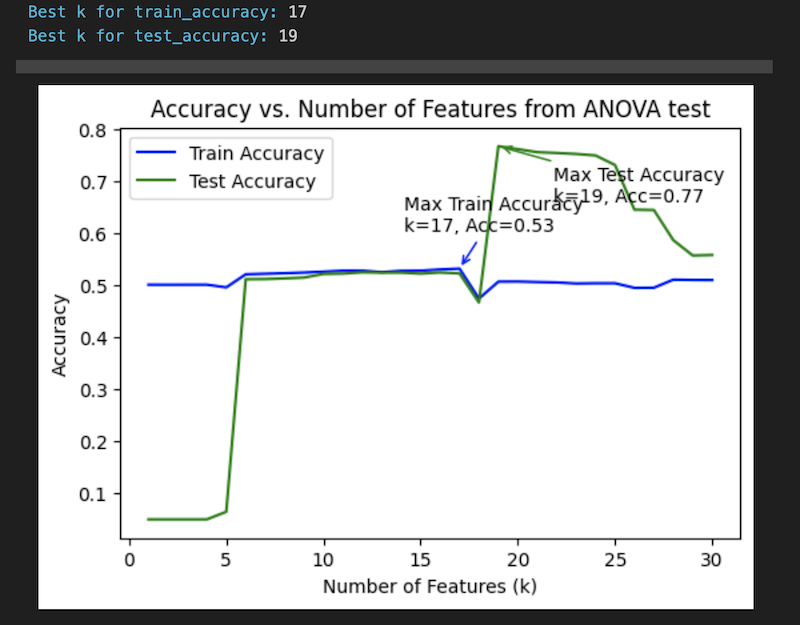

In [109]:
from IPython import display

display.Image("./SVM_find_best_k_ANOVA.png", width=400)

In [110]:
best_train_test_dataset = get_df_with_top_k_features(k_features, *train_test_dataset)

# Now we create a SVM model based on the top 19 features after ANOVA test, and sigmoid as kernel
SVM_model2 = SVM_return_model(*best_train_test_dataset, kernel_type_=best_kernel_type)

X_train1, X_test1, y_train1, y_test1 = best_train_test_dataset
conf_matrix = confusion_matrix(y_test1, y_test1)


kernel_type: sigmoid
Confusion Matrix:
 [[2375  624]
 [ 111   41]]
Accuracy: 0.767
Precision Score: 0.062
Recall Score: 0.27
F1 Score: 0.1
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87      2999
           1       0.06      0.27      0.10       152

    accuracy                           0.77      3151
   macro avg       0.51      0.53      0.48      3151
weighted avg       0.91      0.77      0.83      3151

train_accuracy: 0.505994005994006


The Support Vector Machine (SVM) model has not performed as expected in our analysis for several reasons:

1. **Sensitivity to Outliers**: SVM is particularly sensitive to outliers. In our dataset, we retained outliers to capture distinctive characteristics of different companies with respect to their bankruptcy status. This sensitivity can lead to skewed decision boundaries, adversely affecting model performance. 

2. **Overfitting Issues**: In this analysis, the SVM model has shown a tendency to overfit. This issue stems from the lack of an appropriate regularization function. Without proper regularization, SVM models can overly conform to the noise in the training data rather than capturing the general pattern, leading to poor generalization on new, unseen data.

Hence, this prompt us to improve our SVM model with grid search method.

In [111]:
# defining parameter range
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}

# grid = GridSearchCV(SVM_model2, param_grid, refit=True, verbose=3)
# commented out because it takes >40 minutes to run

# fitting the model for grid search
# grid.fit(X_train1, y_train1)

From grid-search above, we found that the best hyperparameters are:
C=1, gamma=0.1, kernel=poly
Where the average accuracy score after cross-validation is 0.5122

In [112]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Create the SVC model with specified parameters
svm_model_after_gridsearch = SVC(C=1, gamma=0.1, kernel="poly")
svm_model_after_gridsearch.fit(X_train1, y_train1)

# Predictions on the testing set
y_pred_train = svm_model_after_gridsearch.predict(X_train1)
y_pred_test = svm_model_after_gridsearch.predict(X_test1)

# Evaluating the model
train_accuracy = accuracy_score(y_train1, y_pred_train)

print("\nSVM model with grid-search")
print_res(y_test1, y_pred_test)
print(f"train_accuracy: {train_accuracy}")


SVM model with grid-search
Confusion Matrix:
 [[ 251 2748]
 [   8  144]]
Accuracy: 0.125
Precision Score: 0.05
Recall Score: 0.947
F1 Score: 0.095
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.08      0.15      2999
           1       0.05      0.95      0.09       152

    accuracy                           0.13      3151
   macro avg       0.51      0.52      0.12      3151
weighted avg       0.92      0.13      0.15      3151

train_accuracy: 0.5239046667618096


#### 3.3.4 Decision Tree
A Decision Tree  works by splitting the dataset into smaller subsets based on feature values, thereby creating a tree structure. Each split is strategically made to maximize information gain—the reduction in entropy or disorder after the split. 

In [113]:
X_train, X_test, y_train, y_test = pre_process(df)  # with drop_high_core with smote

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2633  366]
 [ 101   51]]
Accuracy: 0.852
Precision Score: 0.122
Recall Score: 0.336
F1 Score: 0.179
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      2999
           1       0.12      0.34      0.18       152

    accuracy                           0.85      3151
   macro avg       0.54      0.61      0.55      3151
weighted avg       0.92      0.85      0.88      3151



With grid search, we found the Best parameters: `{'max_depth': 40, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}`.
We further explore the model performance:

In [114]:
dt = DecisionTreeClassifier(
    max_depth=40, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2629  370]
 [  97   55]]
Accuracy: 0.852
Precision Score: 0.129
Recall Score: 0.362
F1 Score: 0.191
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      2999
           1       0.13      0.36      0.19       152

    accuracy                           0.85      3151
   macro avg       0.55      0.62      0.55      3151
weighted avg       0.92      0.85      0.88      3151



#### 3.3.5 Random Forest
Random forest method is introduced as an improvement over single decision trees to reduce overfitting and improve predictive performance. Two underlying principles of random forest are:
1. **Bagging**: It creates multiple subsets of the training data through random sampling with replacement and using these subsets to train a collection of decision trees (weak learners). This method aims to reduce variance of prediction result.
2. **Random Subspace**: The random forest randomly selects a subset of features  from the original feature set for each individual decision tree within the ensemble. By allowing each tree to focus on a different subset of features, the random forest can capture different patterns and relationships within the data, leading to more accurate and stable predictions.

In [115]:
# random forest initial trial
X_train, X_test, y_train, y_test = pre_process(df)  # with drop_high_core with smote

rdt = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rdt.fit(X_train, y_train)
y_pred = rdt.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2062  937]
 [  52  100]]
Accuracy: 0.686
Precision Score: 0.096
Recall Score: 0.658
F1 Score: 0.168
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81      2999
           1       0.10      0.66      0.17       152

    accuracy                           0.69      3151
   macro avg       0.54      0.67      0.49      3151
weighted avg       0.93      0.69      0.78      3151



In [116]:
# random forest with grid search best model
rdt = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)

rdt.fit(X_train, y_train)
y_pred = rdt.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2877  122]
 [ 122   30]]
Accuracy: 0.923
Precision Score: 0.197
Recall Score: 0.197
F1 Score: 0.197
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2999
           1       0.20      0.20      0.20       152

    accuracy                           0.92      3151
   macro avg       0.58      0.58      0.58      3151
weighted avg       0.92      0.92      0.92      3151



During the model fitting process, we found out that the model could overfit on the training data, hence we proceed to reduce the dimension of our data with feature selection using forward selection loop.

In [117]:
X, y = process0(df)  # get all features, without SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=3244
)

rdt_selected = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)


# selected features from forward_feature_selection function
# takes very long to run, not included in report
# please refer to random forest jupyter notebook
selected_features = [
    "Attr42",
    "Attr58",
    "Attr27",
    "Attr9",
    "Attr19",
    "Attr31",
    "Attr36",
    "Attr56",
    "Attr23",
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


rdt_selected.fit(X_train_selected, y_train)
y_pred_selected = rdt_selected.predict(X_test_selected)

print_res(y_test, y_pred_selected)

Confusion Matrix:
 [[2999    0]
 [ 149    3]]
Accuracy: 0.953
Precision Score: 1.0
Recall Score: 0.02
F1 Score: 0.039
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      2999
           1       1.00      0.02      0.04       152

    accuracy                           0.95      3151
   macro avg       0.98      0.51      0.51      3151
weighted avg       0.95      0.95      0.93      3151



#### 3.3.6 Balanced Random Forest (BRF)
The Balanced Random Forest (BRF) method enhances the traditional Random Forest by specifically addressing class imbalance in training datasets. This approach boosts predictive accuracy and fairness for unbalanced data. BRF tackles Random Forest’s limitations by ensuring equal class representation in each bootstrap sample, achieved through either downsampling or oversampling. Hence, SMOTE method is not utilised in the BRF model as it does not improve the performance. The following code demonstrates the BRF implementation on an imbalanced insurance dataset.

In [118]:
# balanced random forest initial trial
X, y = process0(df)  # get all features, without SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=3244
)

brf = BalancedRandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2069  930]
 [  44  108]]
Accuracy: 0.691
Precision Score: 0.104
Recall Score: 0.711
F1 Score: 0.182
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81      2999
           1       0.10      0.71      0.18       152

    accuracy                           0.69      3151
   macro avg       0.54      0.70      0.50      3151
weighted avg       0.94      0.69      0.78      3151



In [119]:
# balanced random forest with grid search best model
brt = BalancedRandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},  # this is manually adjusted
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)

brt.fit(X_train, y_train)
y_pred = brt.predict(X_test)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2229  770]
 [  52  100]]
Accuracy: 0.739
Precision Score: 0.115
Recall Score: 0.658
F1 Score: 0.196
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      2999
           1       0.11      0.66      0.20       152

    accuracy                           0.74      3151
   macro avg       0.55      0.70      0.52      3151
weighted avg       0.94      0.74      0.81      3151



Same as random forest, one downside of hyperparameter tuning with grid search is that it could potentially lead to overfitting of the training data. We also try to reduce this via forward feature selection.

In [120]:
brf_selected = BalancedRandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},  # manually adjusted classweights
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)


# selected features from filter method (takes very long to run, not included in report)
# please refer to balancedRF jupyter notebook
selected_features = [
    "Attr24",
    "Attr14",
    "Attr27",
    "Attr22",
    "Attr13",
    "Attr34",
    "Attr21",
    "Attr39",
    "Attr41",
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


brf_selected.fit(X_train_selected, y_train)
y_pred = brf_selected.predict(X_test_selected)

print_res(y_test, y_pred)

Confusion Matrix:
 [[2516  483]
 [  53   99]]
Accuracy: 0.83
Precision Score: 0.17
Recall Score: 0.651
F1 Score: 0.27
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      2999
           1       0.17      0.65      0.27       152

    accuracy                           0.83      3151
   macro avg       0.57      0.75      0.59      3151
weighted avg       0.94      0.83      0.87      3151



#### 3.3.7. XGboost (eXtreme Gradient Boosting)

XGBoost is based on the gradient boosting framework and utilizes decision trees as base learners. It iteratively improves predictions by minimizing a loss function, employing techniques like regularization to prevent overfitting.

Without SMOTE

In [121]:
X_train, X_test, y_train, y_test = process2(df)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    objective="binary:logistic",
    tree_method="hist",
    eta=0.1,
    max_depth=3,
    enable_categorical=True,
)

xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
print_res(y_test, y_pred)

Confusion Matrix:
 [[2997    2]
 [ 125   27]]
Accuracy: 0.96
Precision Score: 0.931
Recall Score: 0.178
F1 Score: 0.298
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2999
           1       0.93      0.18      0.30       152

    accuracy                           0.96      3151
   macro avg       0.95      0.59      0.64      3151
weighted avg       0.96      0.96      0.95      3151



With SMOTE

In [122]:
X_train, X_test, y_train, y_test = pre_process(df)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    objective="binary:logistic",
    tree_method="hist",
    eta=0.1,
    max_depth=3,
    enable_categorical=True,
)

xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
print_res(y_test, y_pred)

Confusion Matrix:
 [[2554  445]
 [  66   86]]
Accuracy: 0.838
Precision Score: 0.162
Recall Score: 0.566
F1 Score: 0.252
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      2999
           1       0.16      0.57      0.25       152

    accuracy                           0.84      3151
   macro avg       0.57      0.71      0.58      3151
weighted avg       0.94      0.84      0.88      3151



#### 3.3.8 Deep learning 

Here, we explore the use of neural network for binary classification. Neural networks are a deep learning method consisting of hidden layers. Neural networks can be trained to discern between the two classes by processing input data through multiple hidden layers, each performing a series of transformations on the data. 

In [123]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = pre_process(df)
print(X_train.shape)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

print(encoder.classes_)

(14014, 30)
[0 1]


In [ ]:
import torch

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Here, we consider a wide and deep neural network.  
- Wide -> Only one layer
- Deep -> Several layers

In [ ]:
import torch.nn as nn

feature_num = 30


class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(feature_num, 60)
        self.relu = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(feature_num, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


def train_nn(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250
    batch_size = 1000
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf  # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:

                X_batch = X_train[start : start + batch_size]
                y_batch = y_train[start : start + batch_size]

                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(loss=float(loss), acc=float(acc))

        # evaluate accuracy
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    # get model with best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
wide_model = Wide()
acc = train_nn(wide_model, X_train, y_train, X_test, y_test)
print("Accuracy (wide): %.2f" % acc)

deep_model = Deep()
acc = train_nn(deep_model, X_train, y_train, X_test, y_test)
print("Accuracy (deep): %.2f" % acc)

The model accuracy across different runs is very variable. However, on average, the accuracy is around 0.05, which is very low. This is because neural networks do not generally do well on tabular data. 

## Chapter 4: Numerical results

After experimenting with different models and different feature selection and fine-tuning methods, we have summarise the model metrics below.

|No | Model| Feature Selection | With SMOTE | Model Improvement methods| Test Accuracy	| Precision |	Recall | F1-score |
|:---------:|:--------:|:---------:|:---------:|:--------:|:---------:|:---------:|:--------:|:---------:|
| 1 | Logistic         | ANOVA (k=15)      | yes        |                           | 0.57     | 0.05      | 0.53   | 0.09 |
| 2 | KNN              | PCA               | yes        | K-fold cross validation   | 0.909    | 0.188     | 0.342  | 0.242|
| 3 | KNN              |                   | yes        | Bagging                   |0.966    | 1         | 0.194  | 0.325|
| 4 | Random Forest    | selection loop    | yes        | Grid-search               |  0.906    | 0.23      | 0.5    | 0.31 |
| 5 | SVM              | ANOVA (k=25)      | yes        | kernel= sigmoid           |0.601    | 0.04      | 0.38   | 0.07 |
| 6 | SVM              | ANOVA (k=25)      | yes        | Grid-search               |  0.54     | 0.07      | 0.77   | 0.13 |
| 7 | Decision Tree    | get_train_test    | no         |                           | 0.919          | 0.185    | 0.197     | 0.191  |      |
| 8 | Decision Tree    |                   | yes        |                           | 0.865          | 0.138    | 0.342     | 0.197  |      |
| 9 | Decision Tree    |                   | no         | Grid-search               | 0.933          | 0.237    | 0.178     | 0.203  |      |
|10 | Decision Tree    |                   | yes        | Grid-search               | 0.861          | 0.137    | 0.355     | 0.198  |      |
|11 | XGBoost          |                   | no         |                           | 0.96           | 0.931    | 0.178     | 0.298  |      |
|12 | XGBoost          |                   | yes        |                           | 0.838          | 0.162    | 0.566     | 0.252  |      |
|13 | Balanced RF      | selection loop    | no         | grid_search, classweight  | 0.83          | 0.17    | 0.65     | 0.33   | 
|14 | Neural Network (Wide)|   | yes        |   | 0.05          |  - |   -   |   - | 
|15 | Neural Network (Deep)|     | yes         |  | 0.06          |-     |    -   |  - | 

Overall, we see that the top 3 models are:
1. Random Forest (Model No.3)
2. Balanced RF   (Model No.13)
3. XGBoost       (Model No.11)

Among precision and recall, we prioritise getting higher recall score, meaning, we want to avoid getting FN, which occurs when companies that are going to be bankrupt are predicted as not-bankrupt. In other words, when failing companies are wrongly predicted as successful. Because, companies predicted as not bankrupt might perform actions that put their financial situation at further risks. Thus, failure to detect bankruptcy is very risky. 
Note: High recall = TP / (TP + FN)